# **Modul: 3030 - GSA**


**Autoren:**  
Fabian Rüfenacht  
 Prof. Dr. Dante Salvini

Datum: 15.10.2024


# Geodätische Statistik & Ausgleichsrechnung - Freie Stationierung

Die im Feldkurs in Brienz (BE) durchgeführte Freie Stationierung soll mit Hilfe einer 
vermittelnden Ausgleichung nachgerechnet und mit der App-Lösung von Captivate 
auf der MS60 verglichen werden.

Es ist sicherzustellen, dass die im Felde gemessenen atmosphärisch korrigierten
Distanzen als Projektionsdistanzen (= in der Projektionsebene reduzierte Distanz) 
in der Ausgleichung verwendet werden (im LQP von Leica Geosystems sind diese 
nicht dokumentiert). Die Distanzreduktion ist allenfalls vorgängig zu berechnen.

### 1. Zielsetzung

Anhand der bisher vermittelten Theorie soll eine Freie Stationierung mittels 
Ausgleichung «manuell» berechnet werden, um das Prinzip der vermittelnden
Ausgleichung anhand eines eigenen nummerischen Beispiels praktisch zu 
vertiefen.

### 3. Aufgabenstellung

Die Freie Station soll mittels einer vermittelnden Ausgleichung streng ausgeglichen 
werden, und zwar in einer ersten Variante ohne Massstabsunbekannte und in einer 
zweiten Variante mit Massstabsunbekannte.
Gesucht sind:
- Die ausgeglichenen Koordinaten (nur Lage) der Freien Stationierung
- Genauigkeit der Koordinaten

### 3. Vorgehen
#### 3.1. Ausgleichung
1. Bestimmen Sie die Projektionsdistanzen (Vorbereitungsarbeit, falls nötig)
2. Veranschaulichen Sie die Situation graphisch und tragen Sie die n Beobachtungen und die u Unbekannten der Aufgabenstellung ein
3. Stellen Sie die Beobachtungsgleichungen auf (funktionales Modell)
4. Legen Sie die Näherungswerte für die Unbekannten fest
5. Bilden Sie anschliessend die Verbesserungsgleichungen und bestimmen Sie die Absolutglieder (f Vektor)
6. Berechnung Sie die Standardabweichungen der Beobachtungen (stochastisches Modell)
7. Definieren Sie die Gewichte der einzelnen Beobachtungen
8. Stellen Sie das System der Normalgleichungen auf
9. Lösen Sie das Normalgleichungssystem (Berechnung der Unbekannten)
10. Berechnung der ausgeglichenen Koordinaten der Freien Station
11. Bestimmen Sie die Verbesserungen an den Beobachtungen
12. Bestimmen Sie die ausgeglichenen Beobachtungen
13. Führen Sie die Schlussprobe und den Modelltest durch

#### 3.2 Genauigkeit (am 22.10.2024)
1. Bestimmen Sie die Anzahl der Messungen (n), der Unbekannten (u) und den Freiheitsgrad (f) der Ausgleichung.
2. Berechnen Sie die Genauigkeit der Koordinaten der Freien Station

### 4. Beobachtungen
Als Beobachtungen führen Sie Ihre eigenen Messungen aus dem Feldkurs in Brienz (2024) ein.

### 5. Hilfsmittel
Es wird empfohlen das vorliegende Jupyter-Notebook zu verwenden.


# Einrichten der Umgebung

**Systemvoraussetzungen**

Für die Übung müssen folgende Programme installiert sein. Für ältere Versionen ist die Funktionalität nicht garantiert.

|Programm|Version|
|----|----|
|Conda|24.5.0|
|Python|3.12.4|
|Visual Studio Code (o.ä.)|1.93.0|

**Environment aufsetzen** (nur falls nicht bereits gemacht! sonst nur ```pip install pandas```)

1. starten Sie das die ```Anaconda Prompt```
2. geben Sie folgenden Befehl ein ```conda create -n GSA python=3.12```
3. aktivieren Sie das Environment mit ```conda activate GSA```
4. installieren Sie numpy für Matrixoperationen mit ```pip install numpy pandas```
5. In diesem Notebook:
    - starten Sie VSCode neu
    - klicken Sie oben rechts auf ```Select Kernel``` um das Environment auszuwählen
    - wählen Sie ```Python Environments...``` --> ```GSA```


# Einlesen der Messwerte

In [1]:
import src.lqpReader as lqpReader

lqp_sections = lqpReader.parseLQP("./data/NZ302-Freie.lqp")
resections = lqpReader.get_resections(lqp_sections)
setups = lqpReader.process_resections(resections)
measurements_dict = setups[0] # get all measurements of the first setup

print(measurements_dict)

{'name': 'FS1', 'IH': 1.719, 'O': 2649126.108, 'N': 1178813.282, 'H': 697.749, 'anschluesse': [{'name': 'HZP105', 'O': 2649115.193, 'N': 1178826.107, 'H': 700.06, 'RH': 0.0, 'SD': 16.853, 'HD': 16.842, 'HZ': 355.1112, 'V': 97.7616}, {'name': 'HZP104', 'O': 2649105.133, 'N': 1178824.989, 'H': 699.397, 'RH': 0.0, 'SD': 24.021, 'HD': 24.021, 'HZ': 332.4061, 'V': 100.1884}, {'name': 'HZP103', 'O': 2649093.076, 'N': 1178683.83, 'H': 686.283, 'RH': 0.0, 'SD': 134.248, 'HD': 133.599, 'HZ': 215.9056, 'V': 106.2629}, {'name': 'HZP102', 'O': 2649119.385, 'N': 1178735.619, 'H': 692.215, 'RH': 0.0, 'SD': 78.289, 'HD': 77.952, 'HZ': 205.4967, 'V': 105.9065}]}


# Ausgleichung

1. Projektionsdistanzen bestimmen (vgl. Kapitel 4.3.1 Skript GMTG)

In [2]:
import numpy as np
import src.custom_print as cp
import pandas as pd

RHO = np.pi / 200
ERDRADIUS = 6_378_816 # meter

names = [obs["name"] for obs in measurements_dict["anschluesse"]]


SD = [obs["SD"] for obs in measurements_dict["anschluesse"]] # Schrägdistanzen in Liste schreiben
V = [obs["V"] for obs in measurements_dict["anschluesse"]] # Zenitwinkel in Liste schreiben
e_coord = [obs["O"] for obs in measurements_dict["anschluesse"]] # Ostkoordinaten Anschlusspunkte in Liste schreiben
n_coord = [obs["N"] for obs in measurements_dict["anschluesse"]] # Nordkoordinaten Anschlusspunkte in Liste schreiben
heights = [obs["H"] for obs in measurements_dict["anschluesse"]] # Höhen Anschlusspunkte in Liste schreiben
directions = [obs["HZ"] for obs in measurements_dict["anschluesse"]] # Horizonalrichungen in Liste schreiben

dH = [(_schraegdist*np.sin(_zenitwinkel*RHO)) for _zenitwinkel, _schraegdist in zip(V, SD)] #DONE: Horizontaldistanz für jede Messung berechnen. Ersetze ... mit der Berechnung

d0 = [_dh-_dh*(hoehe/(ERDRADIUS+hoehe)) for _dh, hoehe in zip(dH, heights)] # DONE: Distanz auf Höhe 0 berechnen. Ersetze ... mit der Berechnung

d_proj = [(_d0+_d0*((nord-1200000))**2/(2*(ERDRADIUS)**2)) for _d0, nord in zip(d0, n_coord)] # DONE: Projektionsdistanz berechnen. Ersetze ... mit der Berechnung

measurements = pd.DataFrame({ # Resultate in ein neues Dataframe schreiben um sie später einfacher wiederzuverwenden
    "Nr": names,
    "Ost": e_coord,
    "Nord": n_coord,
    "hoehe": heights,
    "HZ": directions,
    "dProj": d_proj
    })

measurements.head()

,Nr,Ost,Nord,hoehe,HZ,dProj
0,HZP105,2649115.193,1178826.107,700.060,355.1112,16.840828
1,HZP104,2649105.133,1178824.989,699.397,332.4061,24.018394
2,HZP103,2649093.076,1178683.830,686.283,215.9056,133.585264
3,HZP102,2649119.385,1178735.619,692.215,205.4967,77.944262


2. Veranschaulichen Sie die Situation graphisch und tragen Sie die n Beobachtungen und die u Unbekannten der Aufgabenstellung ein

Fügen Sie den Screenshot in der untenstehenden Zelle ein.

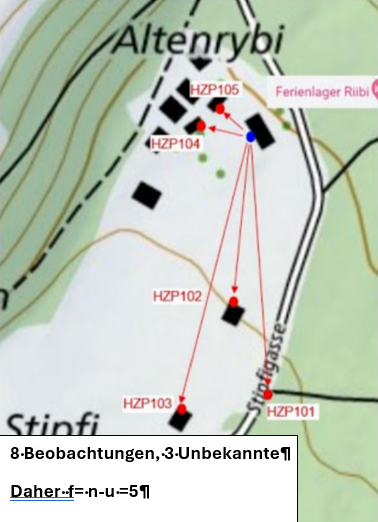

3. Beobachtungsgleichungen aufstellen (funktionales Modell)

Fügen Sie einen Screenshot oder die Formel in der untenstehenden Zelle ein.

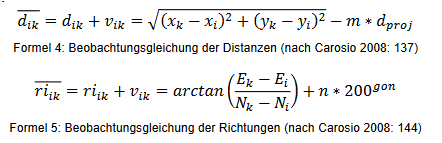

Formelvorlage:
$$Distanz$$
$$\overline{d_{ik}} = d_{ik} + v = \sqrt{(x_{k} - x_{i})^2 + (y_{k} - y_{i})^2} ...$$

$$Richtungen$$
$$\overline{ri_{ik}} = ri_{ik} + v_{ik} = arctan(\frac{E_{k} - E_{i}}{N_{k} - N_{i}})...$$

4. Näherungswerte der Unbekannten & der Beobachtungen

In [3]:
# Näherungswerte der Unbekannten
e_approx_FS = measurements_dict["O"] #Näherungswert FS Ost
n_approx_FS = measurements_dict["N"] #Näherungswert FS Nord


measurements["Azi"] = np.arctan2((measurements["Ost"] - e_approx_FS) , (measurements["Nord"] - n_approx_FS)) / RHO  # TODO: Azimut aus Näherungskoordinate berechnen
measurements["Azi"] = np.where(measurements["Azi"] > 0, measurements["Azi"], measurements["Azi"] + 400) # Falls Azimut <0 ist, muss es korrigiert werden
measurements["Ori"] = measurements["Azi"] - measurements["HZ"]# TODO: Orientierung für jede Beobachtung bessen

ori_approx_FS = np.mean(measurements["Ori"]) #TODO: geeigneten Näherungswert für die Orientierung berechnen
scale_approx_FS = 1 # TODO: geeigneten Näherungswert für den Massstab definieren

unknown_names = ['Ori', 'm', 'N', 'E'] # Namen der Unbekannten
approx_vect = np.array([ori_approx_FS, scale_approx_FS, n_approx_FS, e_approx_FS], np.float64) # Vektor mit allen Näherungswerten erstellen

print(e_approx_FS, n_approx_FS, ori_approx_FS, scale_approx_FS) # Ausgabe der Näherungswerte
print(measurements)

2649126.108 1178813.282 0.0005496689605166694 1
       Nr          Ost         Nord    hoehe        HZ       dProj  \
0  HZP105  2649115.193  1178826.107  700.060  355.1112   16.840828   
1  HZP104  2649105.133  1178824.989  699.397  332.4061   24.018394   
2  HZP103  2649093.076  1178683.830  686.283  215.9056  133.585264   
3  HZP102  2649119.385  1178735.619  692.215  205.4967   77.944262   

          Azi       Ori  
0  355.110911 -0.000289  
1  332.408513  0.002413  
2  215.905096 -0.000504  
3  205.497279  0.000579  


In [4]:
# Näherungswerte der Unbekannten
measurements["naehDist"] = np.sqrt((measurements["Ost"] - e_approx_FS)**2 + (measurements["Nord"] - n_approx_FS)**2)
 #TODO: Distanz aus den Näherungswerten berechnen
measurements["korrHZ"] = measurements["HZ"] + ori_approx_FS
 # TODO: die korrigierte Richtung setzt sich aus der Messung und der Orientierungsunbekannten zusammen.
measurements["korrHZ"] = np.where(measurements["korrHZ"] > 0, measurements["korrHZ"], measurements["korrHZ"] + 400) # Korrektur falls Wert <0

measurements.head()

,Nr,Ost,Nord,hoehe,HZ,dProj,Azi,Ori,naehDist,korrHZ
0,HZP105,2649115.193,1178826.107,700.060,355.1112,16.840828,355.110911,-0.000289,16.840958,355.11175
1,HZP104,2649105.133,1178824.989,699.397,332.4061,24.018394,332.408513,0.002413,24.020917,332.40665
2,HZP103,2649093.076,1178683.830,686.283,215.9056,133.585264,215.905096,-0.000504,133.599900,215.90615
3,HZP102,2649119.385,1178735.619,692.215,205.4967,77.944262,205.497279,0.000579,77.953450,205.49725


5. Verbesserungsgleichungen aufstellen und A-Matrix sowie f-Vektor bilden

Fügen Sie einen Screenshot der Verbesserungsgleichungen in die untenstehende Zelle ein.

*Bild oder Formel der Verbesserungsgleichungen*
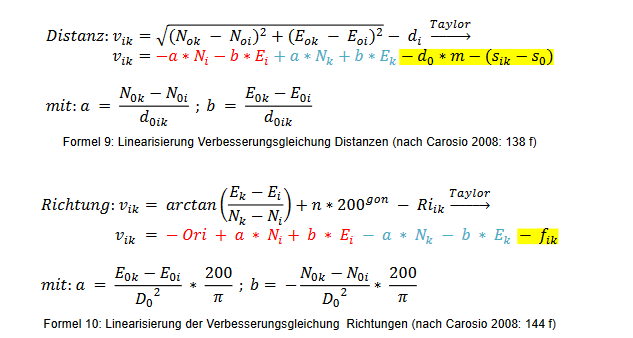


**$$Distanz$$**
$$v_{ik} = -cos(\alpha_{0} * x_{i}) - sin(\alpha_{0} * y_{i}) - d{0} * m - (d_{ik} - d_{0})$$

$$mit:$$
$$d_{0} = Projektionsdistanz \ aus \ Näherungswerten$$
$$d_{ik} = Projektionsdistanz \ aus \ Messung$$

**$$Richtungen$$**

In [5]:
no_obs = 2 * measurements.shape[0] # jeweils Distanz und Richtung
no_unknowns = len(unknown_names) # E, N, Ori, Massstab
A_mat = np.zeros((no_obs, no_unknowns))

for idx, i in measurements.iterrows():    
    # Übertragungsfaktoren Richtung
    A_mat[idx][0] = -1 # TODO: Übertragungsfaktor für die Orientierung berechnen (falls nötig) -->Verbesserungsfunktion nach Ori abltien gibt es -1
    A_mat[idx][1] = 0 # TODO: Übertragungsfaktor für die Distanz berechnen (falls nötig) --> Massstab kommt in Richtung nicht vor darum 0
    A_mat[idx][2] = ((i["Ost"]-e_approx_FS)/(i["naehDist"])**2) / RHO# TODO: Übertragungsfaktor für die Noordkoordinate berechnen (falls nötig) --> Verbesserungsgleichung abgeleitet nach Ni (Ost)
    A_mat[idx][3] = (-1)*(((i["Nord"]-n_approx_FS)/(i["naehDist"])**2)/RHO) # TODO: Übertragungsfaktor für die Ostkoordinate berechnen (falls nötig) --> Verbesserungsgleichung abgeleitet nach Nk (Nord)
    
    # Übertragungsfaktoren Distanz
    A_mat[idx + no_obs // 2][0] = 0 # TODO: Übertragungsfaktor für die Orientierung berechnen (falls nötig) --> In Distanz gibt es keine Ordientierung darum 0
    A_mat[idx + no_obs // 2][1] = (-1)*(i["naehDist"])/1000 # TODO: Übertragungsfaktor für die Distanz berechnen (falls nötig) --> /1000 weil in mm besser ist (Nachkomma lesbar ist)
    A_mat[idx + no_obs // 2][2] = (-1)*((i["Nord"]-n_approx_FS)/i["naehDist"]) # TODO: Übertragungsfaktor für die Noordkoordinate berechnen (falls nöti --> Entwicklte Verbesserungsgleichung abgeleitet nach Ni (Nord)
    A_mat[idx + no_obs // 2][3] = (-1)*((i["Ost"]-e_approx_FS)/i["naehDist"]) # TODO: Übertragungsfaktor für die Ostkoordinate berechnen (falls nötig) --> Entwicklte Verbesserungsgleichung abgeleitet nach Nk (Ost)

obs_names = [str(i) + " ri" for i in names] + [str(i) + " di" for i in names] # Namen der Beobachtungen in einer Liste speichern  

cp.mat_nxu(A_mat, row_names=obs_names, col_names=unknown_names)

           Ori       m       N       E
HZP105 ri -1.0  0.0000 -2.4500 -2.8787
HZP104 ri -1.0  0.0000 -2.3142 -1.2917
HZP103 ri -1.0  0.0000 -0.1178  0.4617
HZP102 ri -1.0  0.0000 -0.0704  0.8136
HZP105 di  0.0 -0.0168 -0.7615  0.6481
HZP104 di  0.0 -0.0240 -0.4874  0.8732
HZP103 di  0.0 -0.1336  0.9690  0.2472
HZP102 di  0.0 -0.0780  0.9963  0.0862


In [6]:
f_HZ = list(measurements["korrHZ"]-measurements["Azi"]) # TODO: Berechnen des Absolutigliedes für Horizontalrichtungen. Ersetzen Sie ... mit der Berechnung. --> Messung -genähert der Richtung 
f_dist = list(measurements["dProj"]-measurements["naehDist"]) # TODO: Berechnen des Absolutigliedes für Distanzen. Ersetzen Sie ... mit der Berechnung. -->Messung - genähert der Distanz
f_vect = np.array(f_HZ + f_dist, np.float64) * 1000 # in mm / mgon umrechnen, damit die Resultate in geeigneter Einheit erscheinen. Die beiden Listen (f_HZ & F_dist) werden aneinandergereiht. --> Alles in eine Liste schreiben


cp.vect(f_vect, row_names=obs_names, unknowns=True)

                  
HZP105 ri   0.8385
HZP104 ri  -1.8635
HZP103 ri   1.0539
HZP102 ri  -0.0290
HZP105 di  -0.1294
HZP104 di  -2.5237
HZP103 di -14.6363
HZP102 di  -9.1874


c:\Users\Marco\OneDrive\FHNW\Semester_3\3D-Datenauswertung\Übung_freie_Stationierung\u04-freie-stationierung-9Marco9-main(3)\u04-freie-stationierung-9Marco9-main\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


6. Standardabweichungen der Beobachtungen (stochastisches Modell)

In [7]:
# folgende 4 Werte können bei Bedarf verändert werden
SIGMA0 = 1
SIGMARI = 0.3 #mgon
sigma_Di_const = 1
sigma_Di_ppm = 1.5

# Funktion zur Berechnung der Genauigkeit der Distanz
def getSigmaDi(distance: float) -> float:
    return sigma_Di_const + sigma_Di_ppm * distance / 1000 #TODO: 0 mit der Berechnung ersetzen. Resultat soll die Genauigkeit einer Messung sein
    
measurements["stabwRI"] = SIGMARI # TODO: 0 mit Genauigkeit einer Richtungsmessung ersetzen. Es wird nicht über die Distanz gewichtet
measurements["stabwDist"] = getSigmaDi(distance=measurements["naehDist"]) # Berechnen der Stabw. einer Distanz
print(measurements.head())

std_obs = np.array(list(measurements["stabwRI"]) + list(measurements["stabwDist"]), np.float64) # Die Standardabweichungen werden in einen Vektor geschrieben

cp.vect(std_obs, row_names=obs_names, title="Stab. Beob.")

       Nr          Ost         Nord    hoehe       HZ    dProj      Azi  \
0  HZP105 2649115.1930 1178826.1070 700.0600 355.1112  16.8408 355.1109   
1  HZP104 2649105.1330 1178824.9890 699.3970 332.4061  24.0184 332.4085   
2  HZP103 2649093.0760 1178683.8300 686.2830 215.9056 133.5853 215.9051   
3  HZP102 2649119.3850 1178735.6190 692.2150 205.4967  77.9443 205.4973   

      Ori  naehDist   korrHZ  stabwRI  stabwDist  
0 -0.0003   16.8410 355.1117   0.3000     1.0253  
1  0.0024   24.0209 332.4066   0.3000     1.0360  
2 -0.0005  133.5999 215.9061   0.3000     1.2004  
3  0.0006   77.9534 205.4972   0.3000     1.1169  
           Stab. Beob.
HZP105 ri       0.3000
HZP104 ri       0.3000
HZP103 ri       0.3000
HZP102 ri       0.3000
HZP105 di       1.0253
HZP104 di       1.0360
HZP103 di       1.2004
HZP102 di       1.1169


c:\Users\Marco\OneDrive\FHNW\Semester_3\3D-Datenauswertung\Übung_freie_Stationierung\u04-freie-stationierung-9Marco9-main(3)\u04-freie-stationierung-9Marco9-main\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


7. Gewichte der Beobachtungen festlegen und Gewichtsmatrix P bilden

In [8]:
p_i = (SIGMA0/std_obs)**2 # TODO: 0 mit der Berechnung der Gewichte ersetzen

P_mat = np.zeros((no_obs, no_obs))

for idx, i in enumerate(p_i): # Der Vektor (p_i) wird in eine Diagonalmatrix umgerechnet
    P_mat[idx][idx] = i
    
cp.mat_nxn(P_mat, obs_names)

           HZP105 ri  HZP104 ri  HZP103 ri  HZP102 ri  HZP105 di  HZP104 di  \
HZP105 ri    11.1111     0.0000     0.0000     0.0000     0.0000     0.0000   
HZP104 ri     0.0000    11.1111     0.0000     0.0000     0.0000     0.0000   
HZP103 ri     0.0000     0.0000    11.1111     0.0000     0.0000     0.0000   
HZP102 ri     0.0000     0.0000     0.0000    11.1111     0.0000     0.0000   
HZP105 di     0.0000     0.0000     0.0000     0.0000     0.9513     0.0000   
HZP104 di     0.0000     0.0000     0.0000     0.0000     0.0000     0.9317   
HZP103 di     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000   
HZP102 di     0.0000     0.0000     0.0000     0.0000     0.0000     0.0000   

           HZP103 di  HZP102 di  
HZP105 ri     0.0000     0.0000  
HZP104 ri     0.0000     0.0000  
HZP103 ri     0.0000     0.0000  
HZP102 ri     0.0000     0.0000  
HZP105 di     0.0000     0.0000  
HZP104 di     0.0000     0.0000  
HZP103 di     0.6940     0.0000  
HZP102 di     0.

8. Normalgleichungssystem aufstellen *zusammen mit Schritt 9*
9. Berechnung der Unbekannten

In [9]:
N_mat = np.matrix_transpose(A_mat)@P_mat @A_mat #TODO: Berechnung der N-Matrix

cp.mat_nxn(N_mat, unknown_names)

        Ori       m        N        E
Ori 44.4444  0.0000  55.0276  32.1674
m    0.0000  0.0181  -0.1290  -0.0582
N   55.0276 -0.1290 128.6316 109.7076
E   32.1674 -0.0582 109.7076 121.4999


In [10]:
Qxx_mat = np.linalg.inv(N_mat) # Berechnung der Qxx-Matrix = inv(N-Matrix)
cp.mat_nxn(Qxx_mat, unknown_names)

        Ori       m       N       E
Ori  0.0786 -0.3638 -0.0700  0.0422
m   -0.3638 57.7373  0.4688 -0.2993
N   -0.0700  0.4688  0.0966 -0.0684
E    0.0422 -0.2993 -0.0684  0.0587


In [11]:
n_vect =  np.transpose(A_mat)@P_mat @f_vect# TODO: Berechnung des n-Vektors

cp.vect(n_vect, row_names=unknown_names)

           
Ori  0.0000
m    1.9897
N    7.7933
E   -0.2113


c:\Users\Marco\OneDrive\FHNW\Semester_3\3D-Datenauswertung\Übung_freie_Stationierung\u04-freie-stationierung-9Marco9-main(3)\u04-freie-stationierung-9Marco9-main\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


In [12]:
x_vect = Qxx_mat@n_vect # TODO: Berechnung Vektor der verkürzten Unbekannten

cp.vect(x_vect, row_names=unknown_names)

            
Ori  -1.2785
m   118.5939
N     1.6997
E    -1.1411


c:\Users\Marco\OneDrive\FHNW\Semester_3\3D-Datenauswertung\Übung_freie_Stationierung\u04-freie-stationierung-9Marco9-main(3)\u04-freie-stationierung-9Marco9-main\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


10. Ausgeglichene Koordinaten der freien Station

In [13]:
X_vect = approx_vect + x_vect/1000 # TODO: die ausgeglichenen, vollen Unbekannten berechnen

X_vect[1] =  (X_vect[1] - scale_approx_FS) / 1000 + scale_approx_FS # TODO: Massstab korrekt anwenden --> Massstab umwandeln in Meter
# Volle Unbekannte in einzelne Variabeln speichern
FS_E = X_vect[3]
FS_N =  X_vect[2]
FS_Ori =  X_vect[0]
FS_msstb =  X_vect[1]

cp.vect(X_vect, row_names=unknown_names, accuracy=6)

                  
Ori      -0.000729
m         1.000119
N   1178813.283700
E   2649126.106859


c:\Users\Marco\OneDrive\FHNW\Semester_3\3D-Datenauswertung\Übung_freie_Stationierung\u04-freie-stationierung-9Marco9-main(3)\u04-freie-stationierung-9Marco9-main\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


11. Verbesserungen der Beobachtungen

In [14]:
# Berechnen Sie die Verbesserungen mittels Matrixmultiplikation
v_vect_mgon_mm = A_mat @x_vect - f_vect # TODO: Verbesserungen berechnen -> Zieleinheiten sind mm / mgon


cp.vect(v_vect_mgon_mm, row_names=obs_names, title="Verbesserungen [mm, mgon]")

           Verbesserungen [mm, mgon]
HZP105 ri                    -0.4393
HZP104 ri                     0.6825
HZP103 ri                    -0.5025
HZP102 ri                     0.2593
HZP105 di                    -3.9018
HZP104 di                    -2.1498
HZP103 di                     0.1569
HZP102 di                     1.5375


c:\Users\Marco\OneDrive\FHNW\Semester_3\3D-Datenauswertung\Übung_freie_Stationierung\u04-freie-stationierung-9Marco9-main(3)\u04-freie-stationierung-9Marco9-main\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


In [15]:
# Berechnen Sie die Verbesserungen aus der Beobachtungsgleichung
v_BGL = np.zeros((measurements.shape[0] * 2, 1), np.float64) # Null-Vektor mit der richtigen Dimension erstellen

for idx, i in measurements.iterrows():    
    #Verbesserungen der Richtung
    ri_naeh = np.arctan2(i["Ost"]-FS_E,i["Nord"]-FS_N) / RHO #TODO: genäherte Richtung (Azimut) mit den ausgeglichenen Unbekannten berechnen
    ri_naeh = ri_naeh if ri_naeh >= 0 else ri_naeh + 400 # positiv setzen falls nötig
    ri_gem = i["HZ"]+FS_Ori # TODO: gemessene Richtungen mit der ausgeglichenen Orientierung ergänzen
    ri_gem = ri_gem if ri_gem >= 0 else ri_gem + 400 # positiv setzen falls nötig
    v_BGL[idx] = ri_naeh - ri_gem # Verbesserung aus der BGL berechnen
    
    # Verbesserungen Distanz
    v_BGL[idx + measurements.shape[0]] = ((i["Ost"]-FS_E)**2+(i["Nord"]-FS_N)**2)**0.5 -FS_msstb *i["dProj"] # TODO: Verbesserungen der Distanz aus der BGL berechnen

v_BGL_mgon_mm = [v[0] * 1000 for v in v_BGL] # Verbesserungen umrechnen um wieder mm / mgon zu erhalten (für den Vergleich) (erfolgt nächste Lektion)

cp.vect(v_BGL_mgon_mm, row_names=obs_names, title="Verbesserungen aus BGL [mm, mgon]")

           Verbesserungen aus BGL [mm, mgon]
HZP105 ri                            -0.4394
HZP104 ri                             0.6823
HZP103 ri                            -0.5025
HZP102 ri                             0.2593
HZP105 di                            -3.9018
HZP104 di                            -2.1495
HZP103 di                             0.1587
HZP102 di                             1.5386


c:\Users\Marco\OneDrive\FHNW\Semester_3\3D-Datenauswertung\Übung_freie_Stationierung\u04-freie-stationierung-9Marco9-main(3)\u04-freie-stationierung-9Marco9-main\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


12. ausgeglichene Beobachtungen

In [16]:
l_measured = list(measurements["Azi"]) + list(measurements["naehDist"].values) # Beobachtungen in einem Vektor speichern
l_aligned = l_measured + (v_vect_mgon_mm/1000) # TODO: Berechnung der ausgeglichenen Beobachtungen

print("-"*3, "Ausgeglichene Beobachtungen", "-"*3)
cp.vect(l_aligned, row_names=obs_names, title="ausgeglichene Beobachtungen")

print("\n", "-"*3, "Differenz ausgeglichen - gemessen == Verbesserung", "-"*3)
for i in range(len(l_measured)):
    difference = l_aligned[i] - l_measured[i]
    print(f"{difference:.4f}")

--- Ausgeglichene Beobachtungen ---
           ausgeglichene Beobachtungen
HZP105 ri                     355.1105
HZP104 ri                     332.4092
HZP103 ri                     215.9046
HZP102 ri                     205.4975
HZP105 di                      16.8371
HZP104 di                      24.0188
HZP103 di                     133.6001
HZP102 di                      77.9550

 --- Differenz ausgeglichen - gemessen == Verbesserung ---
-0.0004
0.0007
-0.0005
0.0003
-0.0039
-0.0021
0.0002
0.0015


c:\Users\Marco\OneDrive\FHNW\Semester_3\3D-Datenauswertung\Übung_freie_Stationierung\u04-freie-stationierung-9Marco9-main(3)\u04-freie-stationierung-9Marco9-main\src\custom_print.py:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: round(x, accuracy) if isinstance(x, (int, float)) else x)


# Genauigkeit

1. Bestimmen Sie die Anzahl der Messungen (n), der Unbekannten (u) und den Freiheits-grad (f).

In [17]:
n = no_obs # TODO: Anzahl Beobachtungen
u = no_unknowns # TODO: Anzahl unbekannte
f = no_obs-no_unknowns # TODO: Freiheitsgrad berechnen

print(f"Anzahl Messungen: {n}, Anzahl Unbekannte: {u}, Freiheitsgrad: {f}")

Anzahl Messungen: 8, Anzahl Unbekannte: 4, Freiheitsgrad: 4


2. Modelltest

In [18]:
s0 =  ((np.transpose(v_vect_mgon_mm)@P_mat@v_vect_mgon_mm)/f)**0.5 # TODO: s0 berechnen

F = (s0)**2/(SIGMA0)**2 # TODO: Testgrösse F berechnen

MODELLTEST_THRESHHOLD = 1.9449 # TODO: Finden Sie die Grenze für den Modelltest (Tipp: Statistik-Tabellen verwenden)


print(f"Standardabweichung a posteriori: {s0}\nTestgrösse F: {F}")

# Durchführung Modelltest
if F <= MODELLTEST_THRESHHOLD:
    print("Der Modelltest wurde bestanden. Modell akzeptiert!")
else:
    print("Der Modelltest wurde NICHT bestanden. Modell verworfen!")

#Testgrösse heisst das die 8 Messungen signifikant schlechter sind als  angenommen

Standardabweichung a posteriori: 2.809507891382189
Testgrösse F: 7.893334591738793
Der Modelltest wurde NICHT bestanden. Modell verworfen!


3. Genauigkeit der Koordinaten FS

In [19]:
Qxx_mat_diag = np.diag(Qxx_mat)


# Genauigkeiten der Unbekannten berechnen
sE = Qxx_mat_diag[3]**0.5* s0 # TODO: Stabw. Ost-Koordinate
sN = Qxx_mat_diag[2]**0.5* s0 # TODO: Stabw. Nord-Koordinate
sOri =Qxx_mat_diag[0]**0.5* s0 # TODO: Stabw. Orientierung
sMsstb = Qxx_mat_diag[1]**0.5* s0 # TODO: Stabw. Massstab

s_vect = np.array([sOri, sMsstb, sN, sE]) # Genauigkeiten in einem Vektor speichern

print(f"Standardabweichung E: {sE:.4f} mm, Standardabweichung N: {sN:.4f} mm")

Standardabweichung E: 0.6806 mm, Standardabweichung N: 0.8730 mm


4. Schlussprobe

In [20]:
GRENZWERT_VERBESSERUNGEN = 10**(-2) # Wir vergleichen die Verbesserungen im Millimeter-Bereich -> Wenn Verbesserungen auf 0.01 mm / mgon zusammenpassen, sind wir mit den Näherungswerten zufrieden

idx = 0
for v, v_ in zip(v_vect_mgon_mm, v_BGL_mgon_mm):
    assert abs(v - v_) <= GRENZWERT_VERBESSERUNGEN, f"Schlussprobe nicht bestanden! Verbesserung {idx}: {(v - v_):6f}" # Bedeutung der Code-Zeile: "assert" wir gehen davon aus, dass der Betrag der Differenz der Verbesserung < dem Grenzwert ist. Ist dies nicht der Fall werfen wir eine Fehlermeldung -> Test nicht bestanden
    idx += 1
    
print("Schlussprobe bestanden!")

Schlussprobe bestanden!


5. Ausgabe der Unbekannten & Genauigkeit

In [21]:
print(f"Orientierung: {X_vect[0]:.4f} gon ± {s_vect[0]:.2f} mgon")
print(f"Massstab: {X_vect[1]:.6f} ± {s_vect[1]:.2f} ppm")
print(f"Nord: {X_vect[2]:.4f} m ± {s_vect[2]:.2f} mm")
print(f"Ost: {X_vect[3]:.4f} m ± {s_vect[3]:.2f} mm")

Orientierung: -0.0007 gon ± 0.79 mgon
Massstab: 1.000119 ± 21.35 ppm
Nord: 1178813.2837 m ± 0.87 mm
Ost: 2649126.1069 m ± 0.68 mm


6. Berechnung mKa,mKb,omega  à piori

![Formel](./Formel.png)

In [22]:
Qxx_mat_diag = np.diag(Qxx_mat)



# Definieren der Elemente q_xx, q_yy und q_xy

q_xx = Qxx_mat_diag[2]     # q_xx Element aus Qxx Matrix
q_yy = Qxx_mat_diag[3]     # q_yy Element aus Qxx Matrix
q_xy = Qxx_mat[2,3]   # q_xy Element aus Qxx Matrix

# Berechnen mka a priori
mka_apri = SIGMA0**2 * ((q_xx + q_yy) / 2 + np.sqrt(((q_xx - q_yy) / 2)**2 + q_xy**2))**0.5


# Berechnen mkb a priori
mkb_apri = SIGMA0**2 * ((q_xx + q_yy) / 2 - np.sqrt(((q_xx - q_yy) / 2)**2 + q_xy**2))**0.5




# Berechnen von Omega
omega_apri = np.arctan(2*q_xy)/((q_xx-q_yy)+(4*(q_xy)**2)+(q_xx-q_yy)**2) / RHO

# Ausgabe der Daten
print(mka_apri,mkb_apri,omega_apri)


0.3854954822755555 0.08141085508334772 -149.19125969870794


7. Berechnung mKa,mKb,omega à poseriori
Achtung: Hier wird s0 verwendet anstatt SIGMA0 wir  wollen ja mit dem tatsächlich berechneten Werten arbeiten hier bei poseriori.

![Formel](./Formel.png)

In [23]:
# Berechnen mka a priori
mka_apost = s0**2 * ((q_xx + q_yy) / 2 + np.sqrt(((q_xx - q_yy) / 2)**2 + q_xy**2))**0.5


# Berechnen mkb a priori
mkb_apost = s0**2 * ((q_xx + q_yy) / 2 - np.sqrt(((q_xx - q_yy) / 2)**2 + q_xy**2))**0.5




# Berechnen von Omega
omega_apost = np.arctan(2*q_xy)/((q_xx-q_yy)+(4*(q_xy)**2)+(q_xx-q_yy)**2) / RHO

# Ausgabe der Daten
print(mka_apost,mkb_apost,omega_apost)

3.0428448252046714 0.6426031185724226 -149.19125969870794


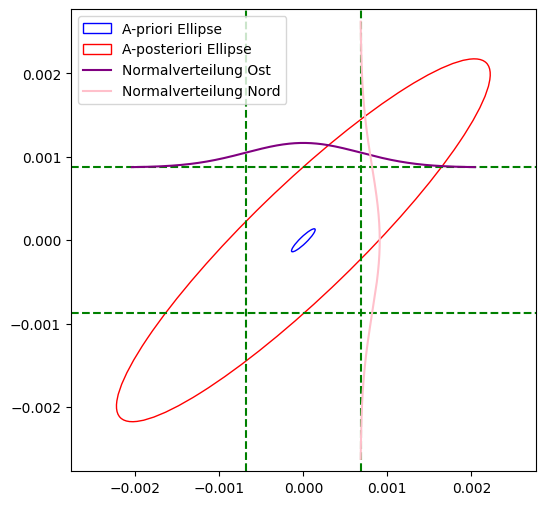

In [24]:
from src.accuracy_plot import plot_1

plot_1(mka_apri,mkb_apri,omega_apri,mka_apost,mkb_apost,omega_apost, sE, sN)

8. Helmertscher Punktfehler

![Helmertscher_Punkt](./Helmertscher_Punkt.png)



In [25]:
Sig_Helm_aprio = (SIGMA0**2) * (q_xx + q_yy)
Sig_Helm_apost = (s0**2) * (q_xx + q_yy)

print(Sig_Helm_aprio, Sig_Helm_apost)

0.15523449418026497 1.2253178027441598


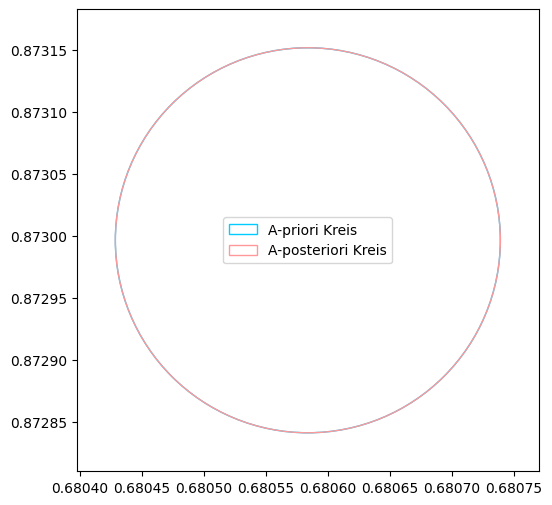

In [26]:
from src.accuracy_plot import plot_2

plot_2(Sig_Helm_aprio,Sig_Helm_aprio,sE, sN)

9. Konfidenzzell 95% à posteriori (a,b,omega)

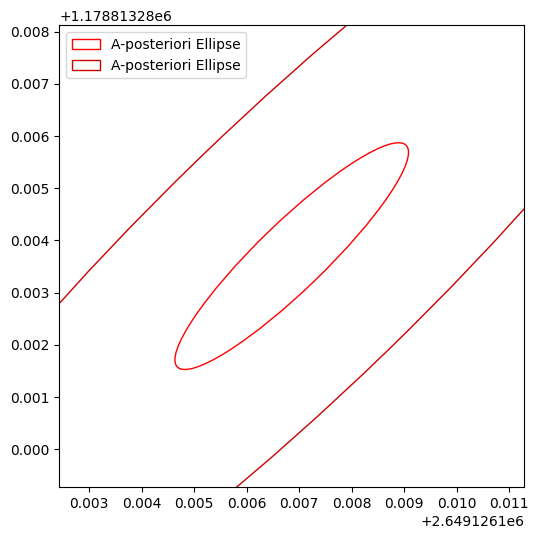

In [33]:
from src.accuracy_plot import plot_3
a95 = mka_apost *4.0
b95 = mkb_apost *4.0






plot_3(mka_apost,mkb_apost, omega_apost, a95, b95, omega_apost, sE, sN, FS_E, FS_N)